# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [1]:
#Import all the required libraries
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.3.0


## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [3]:
#create the dataset from image directory
tr1 = tf.keras.preprocessing.image_dataset_from_directory('dataset/Tr1', color_mode='grayscale', batch_size=1, label_mode=None, image_size=(256, 256), shuffle=True, seed=20)                                                          

Found 43 files belonging to 1 classes.


In [4]:
#create the dataset from image directory
tr2 = tf.keras.preprocessing.image_dataset_from_directory('dataset/Tr2', color_mode='grayscale', batch_size=1, label_mode=None, 
image_size=(256, 256), shuffle=True, seed=20) 

Found 46 files belonging to 1 classes.


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [5]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [6]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [7]:
# process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(128)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(128)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

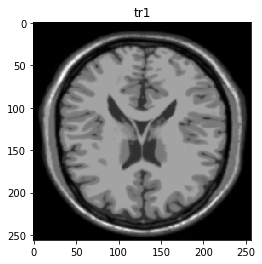

In [9]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

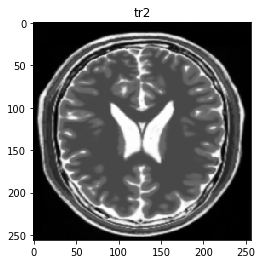

In [10]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [11]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [12]:
def unet_generator():
    down_stack = [downsample(64,4,False),
                  downsample(128,4),
                  downsample(256,4),
                  downsample(512,4),
                  downsample(512,4),
                  downsample(512,4),
                  downsample(512,4),
                  downsample(512,4)
    ]
    up_stack = [ upsample(512, 4, True),
                 upsample(512, 4, True),
                 upsample(512, 4, True),
                 upsample(512, 4),
                 upsample(256, 4),
                 upsample(128, 4),
                 upsample(64, 4)
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
generator_g = unet_generator()
generator_f = unet_generator()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4) (down1)
    down3 = downsample(256, 4) (down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [15]:
discriminator_x = discriminator()
discriminator_y = discriminator()

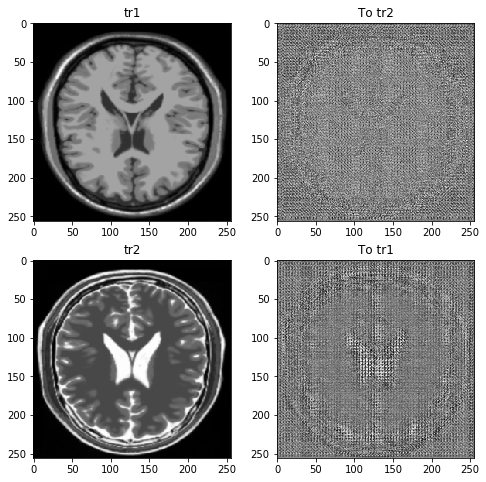

In [16]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [17]:
LAMBDA = 10

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [21]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
EPOCHS = 50

In [25]:
checkpoint_path = "checkpoint"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [26]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [27]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x) 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
        generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
        discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
        generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

        generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


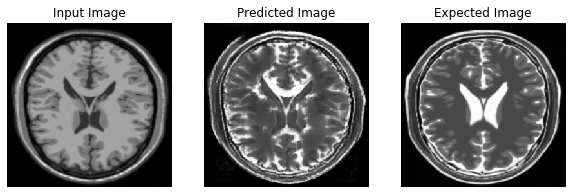

Saving checkpoint for epoch 0 at checkpoint\ckpt-21


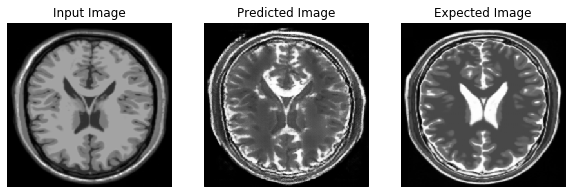

Saving checkpoint for epoch 1 at checkpoint\ckpt-22


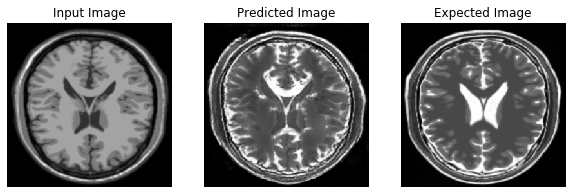

Saving checkpoint for epoch 2 at checkpoint\ckpt-23


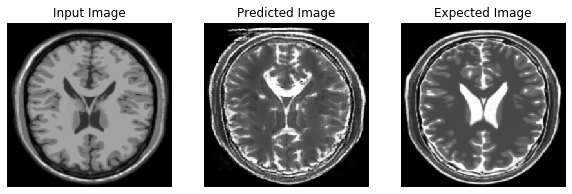

Saving checkpoint for epoch 3 at checkpoint\ckpt-24


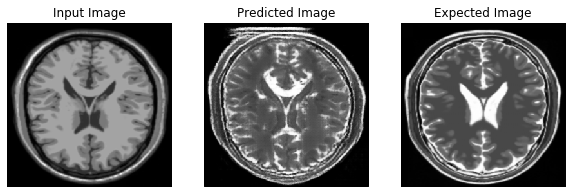

Saving checkpoint for epoch 4 at checkpoint\ckpt-25


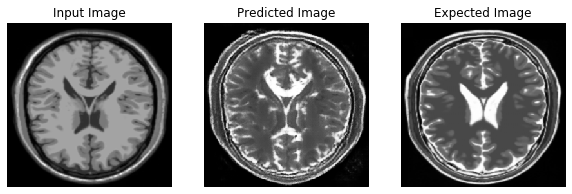

Saving checkpoint for epoch 5 at checkpoint\ckpt-26


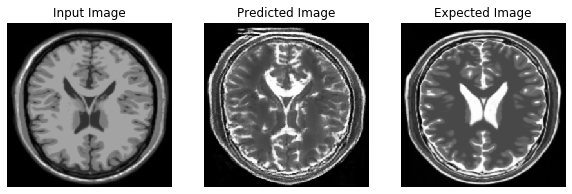

Saving checkpoint for epoch 6 at checkpoint\ckpt-27


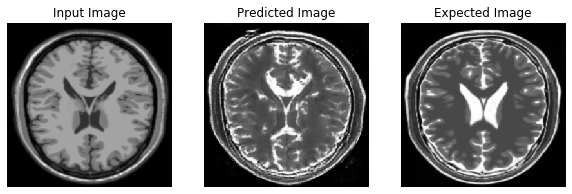

Saving checkpoint for epoch 7 at checkpoint\ckpt-28


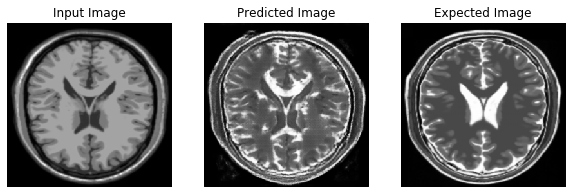

Saving checkpoint for epoch 8 at checkpoint\ckpt-29


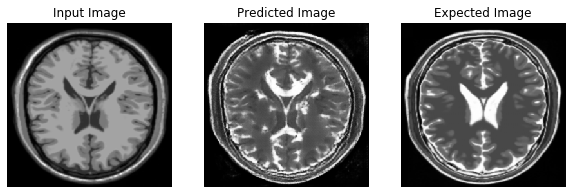

Saving checkpoint for epoch 9 at checkpoint\ckpt-30


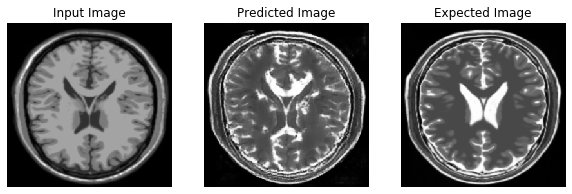

Saving checkpoint for epoch 10 at checkpoint\ckpt-31


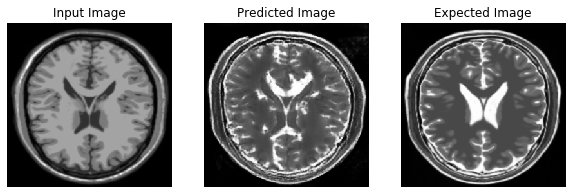

Saving checkpoint for epoch 11 at checkpoint\ckpt-32


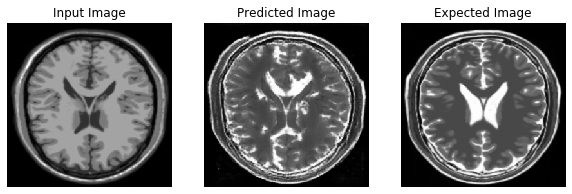

Saving checkpoint for epoch 12 at checkpoint\ckpt-33


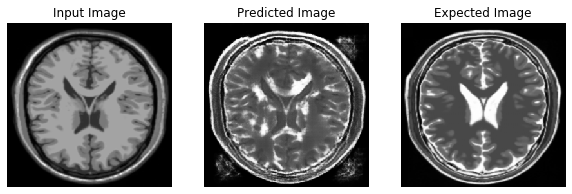

Saving checkpoint for epoch 13 at checkpoint\ckpt-34


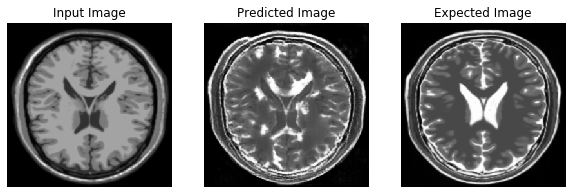

Saving checkpoint for epoch 14 at checkpoint\ckpt-35


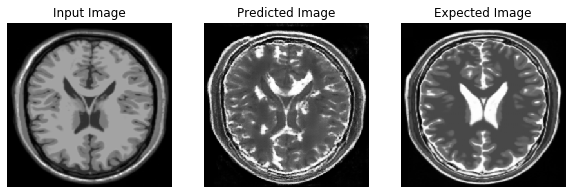

Saving checkpoint for epoch 15 at checkpoint\ckpt-36


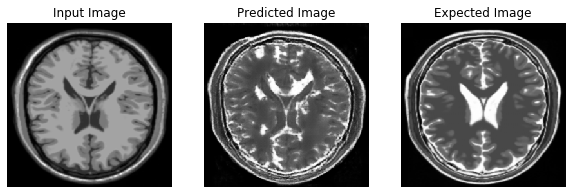

Saving checkpoint for epoch 16 at checkpoint\ckpt-37


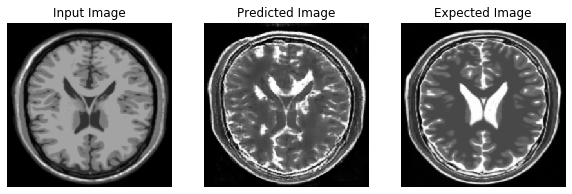

Saving checkpoint for epoch 17 at checkpoint\ckpt-38


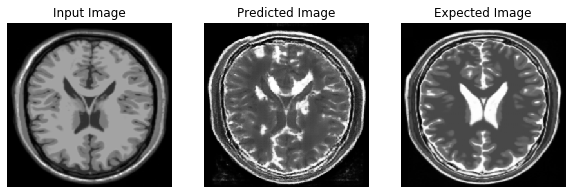

Saving checkpoint for epoch 18 at checkpoint\ckpt-39


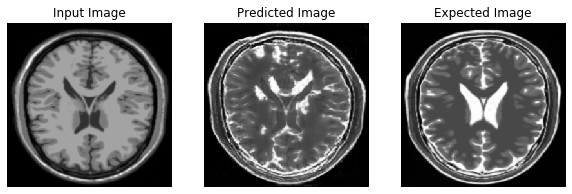

Saving checkpoint for epoch 19 at checkpoint\ckpt-40


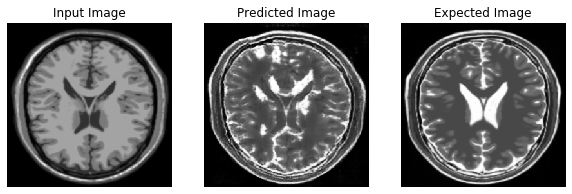

Saving checkpoint for epoch 20 at checkpoint\ckpt-41


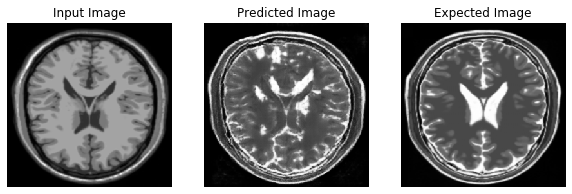

Saving checkpoint for epoch 21 at checkpoint\ckpt-42


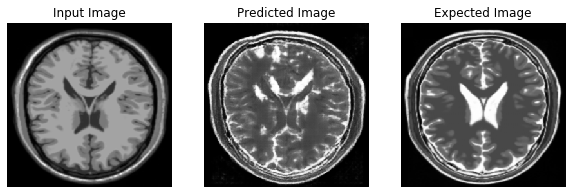

Saving checkpoint for epoch 22 at checkpoint\ckpt-43


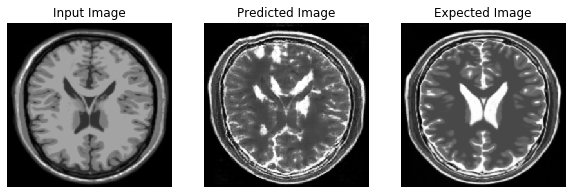

Saving checkpoint for epoch 23 at checkpoint\ckpt-44


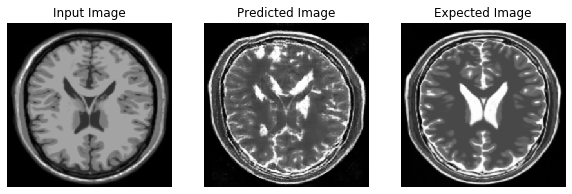

Saving checkpoint for epoch 24 at checkpoint\ckpt-45


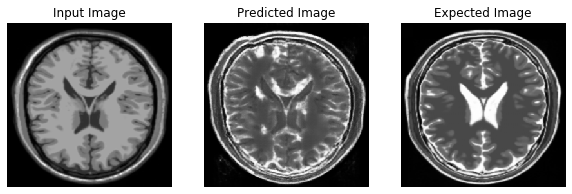

Saving checkpoint for epoch 25 at checkpoint\ckpt-46


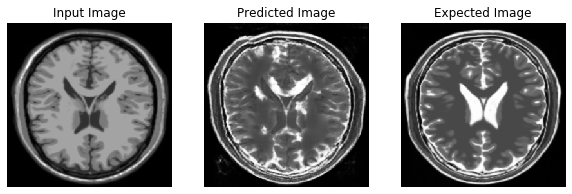

Saving checkpoint for epoch 26 at checkpoint\ckpt-47


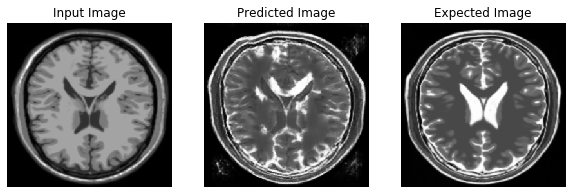

Saving checkpoint for epoch 27 at checkpoint\ckpt-48


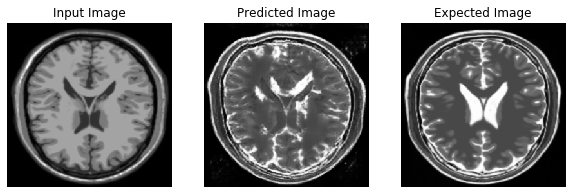

Saving checkpoint for epoch 28 at checkpoint\ckpt-49


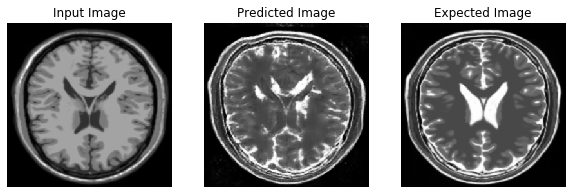

Saving checkpoint for epoch 29 at checkpoint\ckpt-50


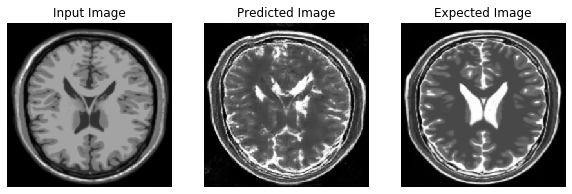

Saving checkpoint for epoch 30 at checkpoint\ckpt-51


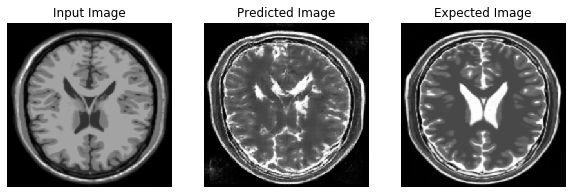

Saving checkpoint for epoch 31 at checkpoint\ckpt-52


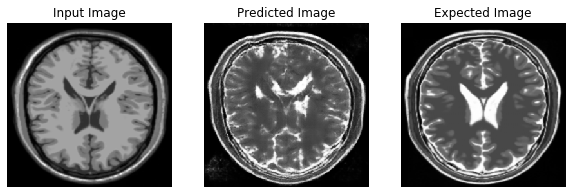

Saving checkpoint for epoch 32 at checkpoint\ckpt-53


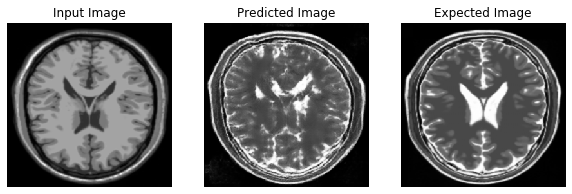

Saving checkpoint for epoch 33 at checkpoint\ckpt-54


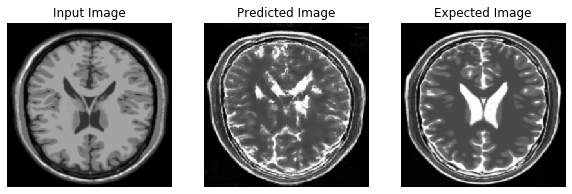

Saving checkpoint for epoch 34 at checkpoint\ckpt-55


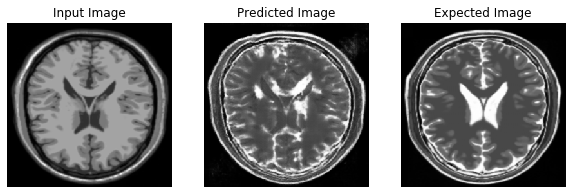

Saving checkpoint for epoch 35 at checkpoint\ckpt-56


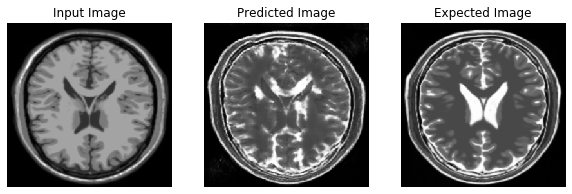

Saving checkpoint for epoch 36 at checkpoint\ckpt-57


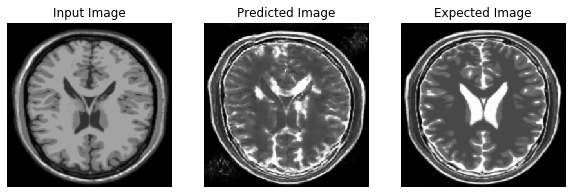

Saving checkpoint for epoch 37 at checkpoint\ckpt-58


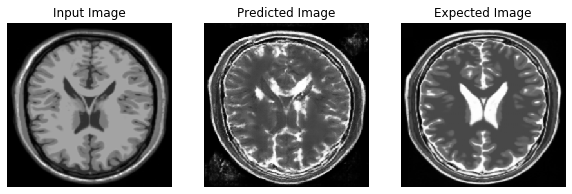

Saving checkpoint for epoch 38 at checkpoint\ckpt-59


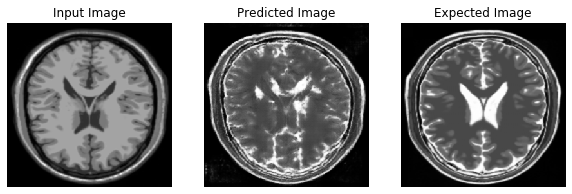

Saving checkpoint for epoch 39 at checkpoint\ckpt-60


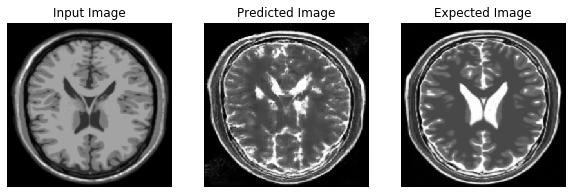

Saving checkpoint for epoch 40 at checkpoint\ckpt-61


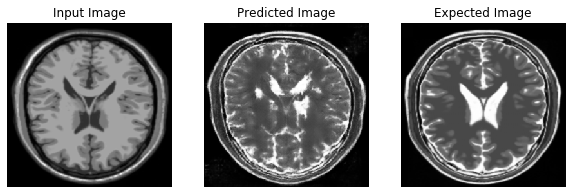

Saving checkpoint for epoch 41 at checkpoint\ckpt-62


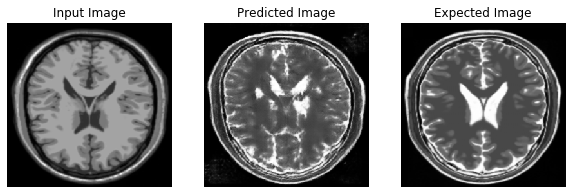

Saving checkpoint for epoch 42 at checkpoint\ckpt-63


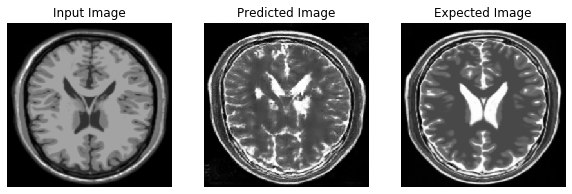

Saving checkpoint for epoch 43 at checkpoint\ckpt-64


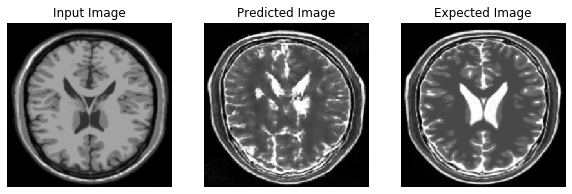

Saving checkpoint for epoch 44 at checkpoint\ckpt-65


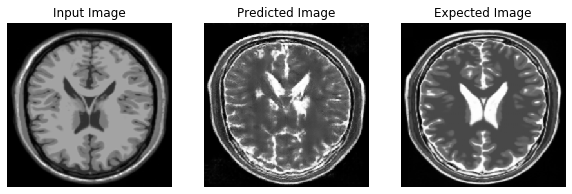

Saving checkpoint for epoch 45 at checkpoint\ckpt-66


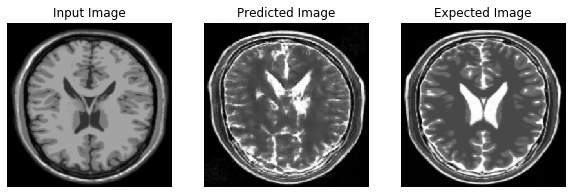

Saving checkpoint for epoch 46 at checkpoint\ckpt-67


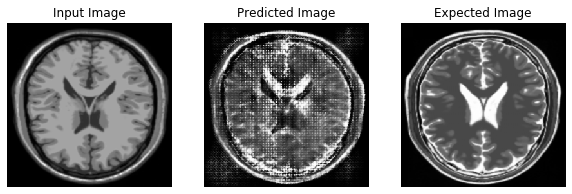

Saving checkpoint for epoch 47 at checkpoint\ckpt-68


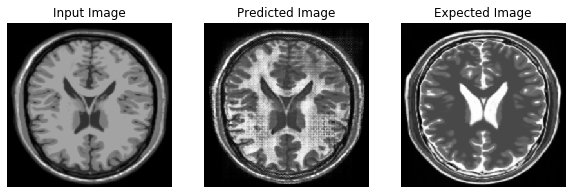

Saving checkpoint for epoch 48 at checkpoint\ckpt-69


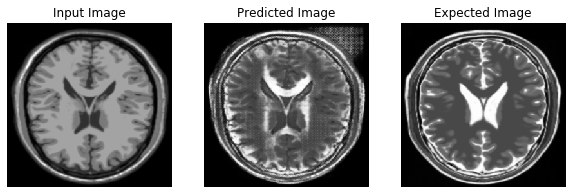

Saving checkpoint for epoch 49 at checkpoint\ckpt-70


In [28]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

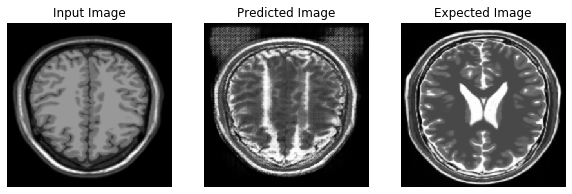

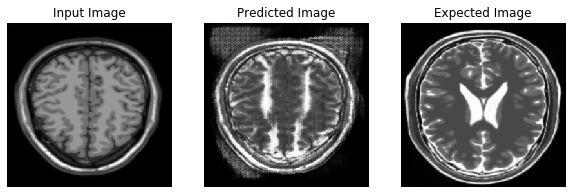

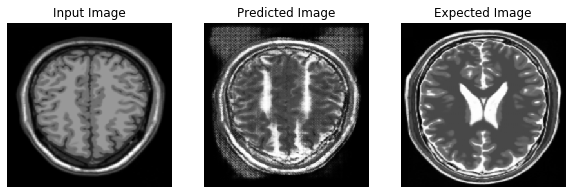

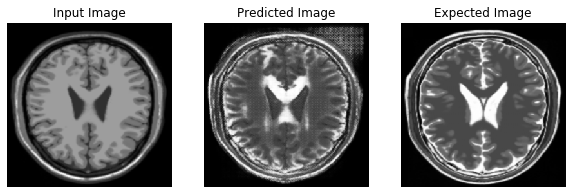

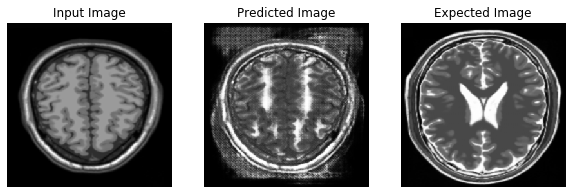

In [29]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)